In [ ]:
# Install all required packages
!pip install git+https://github.com/openai/CLIP.git
!pip install -q -U llama-index chromadb llama-index-vector-stores-chroma llama-index-embeddings-clip llama-index-readers-json
!pip install -q -U bitsandbytes accelerate peft
!pip install vllm

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-p5cm70pb
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-p5cm70pb
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.5 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=eadcc7355833bfc7f0007ef56312993b2c8d7f983cdc4e6aab88325a6b0d0196
  Stored in directory: /tmp/pip-ephem-wheel-cache-1b6hhp_2/wheels/35/3e/df/3d24cbfb3b6a06f17a2bfd7d1138900d4365d9028aa8f6e92f
Successfully built clip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 7.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.9/19.9 MB 128.0 MB/s eta 0:00:00

In [ ]:
import chromadb, os, base64, requests, json, clip, subprocess, time
from typing import List, Dict
import matplotlib.pyplot as plt
from PIL import Image

# -- LLama Index Imports -- #
from llama_index.core.vector_stores.types import VectorStoreQuery
from llama_index.embeddings.clip import ClipEmbedding
from llama_index.vector_stores.chroma import ChromaVectorStore
from llama_index.core.indices import MultiModalVectorStoreIndex
from llama_index.core import StorageContext, QueryBundle, Settings, SimpleDirectoryReader, Document
from llama_index.core.query_engine import SimpleMultiModalQueryEngine
from llama_index.core.indices.multi_modal.retriever import MultiModalVectorIndexRetriever
from llama_index.core.node_parser import SentenceSplitter
from llama_index.readers.json import JSONReader

In [ ]:
# --- Configuration ---
# IMPORTANT: Update this path to your fine-tuned model folder
MODEL_PATH = "/content/drive/MyDrive/APOD/llava-apod-merged"
LOG_FILE = "vllm_server.log"

# Command to start the VLLM server
command = [
    "python", "-m", "vllm.entrypoints.openai.api_server",
    "--model", MODEL_PATH,
    "--trust-remote-code",
    "--gpu-memory-utilization", "0.7"
]

print("Starting LLaVA VLLM server in the background...")
# Open a log file to capture the server's output
with open(LOG_FILE, "w") as log:
    # Use subprocess.Popen to run the command as a background process
    server_process = subprocess.Popen(command, stdout=log, stderr=log)

print(f"Server started with PID: {server_process.pid}. Check '{LOG_FILE}' for status.")
# Wait a bit for the server to initialize
time.sleep(180)
print("Server should be ready.")

Starting LLaVA VLLM server in the background...
Server started with PID: 7973. Check 'vllm_server.log' for status.
Server should be ready.


In [ ]:
# -- VLLM Server Setup -- #
LLAVA_API_BASE = "http://localhost:8000/v1"
LLAVA_MODEL_NAME = "/content/drive/MyDrive/APOD/llava-apod-merged"

def query_llava_server(prompt_text: str, image_path: str = None) -> str:
    """Sends a prompt and a base64-encoded image directly to the VLLM server."""
    print("\n--- Sending request to local LLaVA server ---")
    try:
        with open(image_path, "rb") as img_file:
            encoded_image = base64.b64encode(img_file.read()).decode('utf-8')
    except FileNotFoundError:
        return f"Error: Image file not found at {image_path}"

    headers = {"Content-Type": "application/json"}
    payload = {
        "model": LLAVA_MODEL_NAME,
        "messages": [
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": prompt_text},
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/jpeg;base64,{encoded_image}"}
                    }
                ]
            }
        ],
        "max_tokens": 500
    }

    try:
        response = requests.post(f"{LLAVA_API_BASE}/chat/completions", headers=headers, json=payload)
        response.raise_for_status()
        return response.json()["choices"][0]["message"]["content"]
    except Exception as e:
        return f"Error calling LLaVA server: {e}"

In [ ]:
# --- Set up the Index and Retriever --- #
db = chromadb.PersistentClient(path="multimodal_db")
text_collection = db.get_or_create_collection("text_collection")
image_collection = db.get_or_create_collection("image_collection")
text_store = ChromaVectorStore(chroma_collection=text_collection)
image_store = ChromaVectorStore(chroma_collection=image_collection)
storage_context = StorageContext.from_defaults(vector_store=text_store, image_store=image_store)
clip_embed = ClipEmbedding()

# --- JSON Text Handling --- #

# --- APOD Summaries ---#
# Custom parsing function
def parse_apod_explanations(data: List[Dict]) -> List[str]:
    """
    Parses a list of APOD entries and extracts only the 'explanation' text.
    """
    explanations = []
    for entry in data:
        if "explanation" in entry:
            explanations.append(entry["explanation"])
    return explanations

# Open and load the JSON file using Python's built-in library
file_path = "/content/drive/MyDrive/APOD/DATA/TEXT/apod_data.json"
with open(file_path, 'r', encoding='utf-8') as f:
    json_data = json.load(f)

# Use function to process the loaded data into a list of strings
extracted_texts = parse_apod_explanations(json_data)

# Manually create LlamaIndex Document objects from text
apod_documents = [Document(text=t) for t in extracted_texts]

print(f"APOD Documents: {apod_documents[5]}")

# --- OpenStax Textbook --- #
# Define the parsing function for the OpenStax data structure
def parse_openstax_values(data: Dict[str, str]) -> List[str]:
    """
    Parses an OpenStax-style dictionary and extracts all text values.
    """
    # .values() gets all the text snippets, and list() converts them
    return list(data.values())

# Open and load your OpenStax JSON file
file_path = "/content/drive/MyDrive/APOD/DATA/TEXT/OpenStax_Astronomy2e.json"
with open(file_path, 'r', encoding='utf-8') as f:
    json_data = json.load(f)

# Use the function to extract the text
extracted_texts = parse_openstax_values(json_data)

# Manually create LlamaIndex Document objects
os_documents = [Document(text=t) for t in extracted_texts]

print(f"OpenStax Documents: {os_documents[5]}")

text_docs = apod_documents + os_documents

# Exclude metadata from the embedding
for d in text_docs:
    d.excluded_embed_metadata_keys.extend([
        "file_name",
        "file_type",
        "file_size",
        "creation_date",
        "last_modified_date",
        "file_path"
    ])

splitter = SentenceSplitter(chunk_size=45, chunk_overlap=10)

# Split all documents into nodes
text_nodes = []
for doc in text_docs:
    text_nodes.extend(splitter.get_nodes_from_documents([doc]))

# --- Image Handling --- #
image_docs = SimpleDirectoryReader("/content/drive/MyDrive/APOD/DATA/IMAGES").load_data()


# --- Index Creation --- #
index = MultiModalVectorStoreIndex.from_documents(
    image_docs,
    storage_context=storage_context,
    embed_model=clip_embed,
    image_embed_model=clip_embed,
    show_progress = True,
)

# Insert nodes in batches
BATCH_SIZE = 5461  # Must be <= vector store's max batch size
for i in range(0, len(text_nodes), BATCH_SIZE):
    batch_nodes = text_nodes[i:i+BATCH_SIZE]
    index.insert_nodes(batch_nodes)

100%|███████████████████████████████████████| 338M/338M [00:21<00:00, 16.5MiB/s]


APOD Documents: Doc ID: 763bcd26-8e7a-4c73-8b87-6954ae308f97
Text: Some cloud patterns on Jupiter are quite complex. The featured
tumultuous clouds were captured in May by NASA's robotic Juno
spacecraft currently orbiting our Solar System's largest planet.  The
image was taken when Juno was only about 15,000 kilometers over
Jupiter's cloud tops, so close that less than half of the giant planet
is visible.  The ...
OpenStax Documents: Doc ID: dcb13f42-8a58-4926-bf52-dec94ab8ecc7
Text: In astronomy we deal with distances on a scale you may never
have thought about before, with numbers larger than any you may have
encountered. We adopt two approaches that make dealing with
astronomical numbers a little bit easier. First, we use a system for
writing large and small numbers called  Watch this  A common unit
astronomers use to des...
Metadata length (0) is close to chunk size (45). Resulting chunks are less than 50 tokens. Consider increasing the chunk size or decreasing the size of your met

Parsing nodes:   0%|          | 0/1945 [00:00<?, ?it/s]

Generating image embeddings:   0%|          | 0/1945 [00:00<?, ?it/s]

In [ ]:
# Save Index and DB
index.storage_context.persist(persist_dir="/content/index")
!cp -r /content/index /content/drive/MyDrive/APOD
!cp -r /content/multimodal_db /content/drive/MyDrive/APOD

In [ ]:
# Load index
from llama_index.core import load_index_from_storage
db = chromadb.PersistentClient(path="/content/drive/MyDrive/APOD/multimodal_db")
text_collection = db.get_collection("text_collection")
image_collection = db.get_collection("image_collection")
text_store = ChromaVectorStore(chroma_collection=text_collection)
image_store = ChromaVectorStore(chroma_collection=image_collection)
clip_embed = ClipEmbedding()

storage_context = StorageContext.from_defaults(
    vector_store=text_store, image_store=image_store, persist_dir="/content/drive/MyDrive/APOD/index"
)
index = load_index_from_storage(storage_context, embed_model=clip_embed, image_embed_model=clip_embed)

100%|████████████████████████████████████████| 338M/338M [00:00<00:00, 462MiB/s]


[1.1694117884794197e-13, 3.2880047160419994e-15, 6.693301676107032e-16]

--- Sending request to local LLaVA server ---
Prompt:
 Context information and similarity score is below.
---------------------
Why is Betelgeuse fading?  No one knows.  Betelgeuse, one of the brightest and most recognized stars in the night sky, is only half as bright as it used to be only five months ago.  Such variability is likely just  normal behavior for this famously variable supergiant, but the recent dimming has rekindled discussion on how long it may be before Betelgeuse does go supernova.  Known for its red color, Betelgeuse is one of the few stars to be resolved by modern telescopes, although only barely.  The featured artist's illustration imagines how Betelgeuse might look up close. Betelgeuse is thought to have a complex and tumultuous surface that frequently throws impressive flares.  Were it to replace the Sun (not recommended), its surface would extend out near the orbit of Jupiter, while gas plu

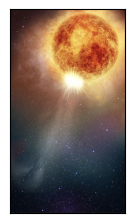

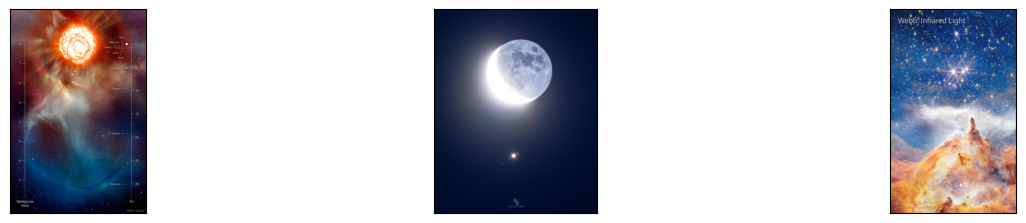

In [ ]:
# --- Image Query --- #
# Image plotting helper function
def plot_images(image_paths):
    images_shown = 0
    plt.figure(figsize=(16, 9))
    for img_path in image_paths:
        if os.path.isfile(img_path):
            image = Image.open(img_path)

            plt.subplot(3, 3, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            images_shown += 1
            if images_shown >= 9:
                break

image_path = "/content/Screenshot2025-10-15at15.58.13.png"
qa_text = "What is in this image?"
plot_images([image_path])

# Manually embed image and query against vector image index
query = VectorStoreQuery(query_embedding=clip_embed.get_image_embedding(img_file_path=image_path),similarity_top_k=3)
query_result = index.image_vector_store.query(query)

file_paths = [node.metadata['file_path'] for node in query_result.nodes]

plot_images(file_paths)
print(query_result.similarities)

image_name = os.path.basename(os.path.normpath(file_paths[0]))
target_date = image_name.removesuffix(".jpg")

#Model will see the image that is uploaded and not the top retrieved one
if image_path != None:
  top_image_path = image_path
else:
    # The first image in the list is the most relevant one
    top_image_path = "/content/drive/MyDrive/APOD/DATA/IMAGES/" + image_name

with open("/content/drive/MyDrive/APOD/DATA/TEXT/apod_data.json", 'r', encoding='utf-8') as f:
        data = json.load(f)

for item in data:
    # Check if the 'date' in the current item matches target date
    if item.get('date') == target_date:
        # If it matches, return the 'explanation'
        image_str = item.get('explanation')

# Append retrieved explanation to this list
context_str = image_str

# --- Call the LLM with the best image and all retrieved text ---

prompt = (
    "Context information and similarity score is below.\n"
    "---------------------\n"
    f"{context_str}\n"
    "---------------------\n"
    "Given the context information and prior knowledge, "
    "answer the query.\n"
    f"Query:{qa_text} .\n"
    "Answer: "
)

final_response = query_llava_server(prompt_text=prompt, image_path=top_image_path)
print("Prompt:\n", prompt)
print("\n--- Final LLaVA Response ---")
print(final_response)

In [ ]:
# -- Text Prompt --
qa_text = "What is the average orbital speed of Neptune?"

query = VectorStoreQuery(query_embedding=clip_embed.get_text_embedding(text=qa_text), similarity_top_k=5)
query_result = index.vector_store.query(query)

retrieved_text = [node.text for node in query_result.nodes]

# Use a space ' ' as the separator to join the strings
context_str = ' '.join(retrieved_text)

prompt = (
    "Context information is below.\n"
    "---------------------\n"
    f"{context_str}\n"
    "---------------------\n"
    "Given the context information and prior knowledge, "
    "answer the query.\n"
    f"Query:{qa_text} .\n"
    "Answer: "
)

final_response = query_llava_server(prompt_text=prompt, image_path="/content/Screenshot 2025-10-15 at 15.58.13.png")
print("Prompt:\n", prompt)
print("\n--- Final LLaVA Response ---")
print(final_response)


--- Sending request to local LLaVA server ---
Prompt:
 Context information is below.
---------------------
Calculations showed where that planet had to be, and Neptune was discovered just about in the predicted location. The distance from Earth to Neptune is about 4.8 billion kilometers. Over this vast distance, It could not have been taken from Earth because Neptune never shows a crescent phase to sunward Earth. averaging 48 kilometers per second. At the opposite extreme, Neptune has a period of 165 years and an average orbital speed of just 5 kilometers per second. As more objects are discovered in these distant reaches, astronomers decided that they will be given the names of 
Beyond the orbit of Neptune lies a cold,
---------------------
Given the context information and prior knowledge, answer the query.
Query:What is the average orbital speed of Neptune? .
Answer: 

--- Final LLaVA Response ---
 According to the information given, the average orbital speed of Neptune is about 5 